# BENG123: Final Project
## Part 3: Simulation Case Studies and Analysis

<font color='red'>**IMPORTANT NOTES:**</font>  
* **The IPYNB files must run from top to bottom without errors. We will run your notebook using the following steps: $$\text{"Kernel}\ \rightarrow\ \text{Restart and Run all"}$$**
* **Make sure you are using the correct versions of packages if you are working outside of JupyterHub
<font color='red'>(masspy==0.1.6, libroadrunner==2.1.3)</font>**
* **Do not leave unneccessary code/comments in the final notebook submission as unorganized code may result in loss of points.**


### Instructions
1. All simulations and figures that you wish to put in the final report should be done in here. Each figure generated must be displayed when the notebook is run. It is recommended to use one cell per figure generated. 


2. A template has been provided to you below to help with code organization. However, you are free to delete the template and use your own organization in this notebook. The only requirement is that this notebook is organized in a logical manner with descriptive headers to help provide clarity. One file can be submitted with all three case studies, or three files can be submitted seperately.


3. Remember to save all figures you wish to include as a .PDF or .PNG file and be sure to include them in the zip file of your final submission. All figures in the final report should have figure numbers, appropriate axis labels, limits and scale, legends and captions, and be referred in the text.


4. Save all figures in the figures folder provided. This can be done through the `figure.savefig` command. 


**Recommendation:** It is recommended to utilize seperate notebooks for each case study to avoid possible errors or artificial results. **Consider duplicating this notebook for each case study performed**. Remember, each case study has a maximum of 3 figures per case study! 

### Import Packages

In [1]:
from mass.io.json import load_json_model
from mass import Simulation
from mass.visualization import plot_time_profile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from copy import deepcopy

pd.set_option('display.max_columns', None)

### Set Up Directories

In [2]:
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
models_dir = os.path.join(parent_dir, "models")
figures_dir = os.path.join(parent_dir, "figures")

# Create figures directory if it doesn't exist
os.makedirs(figures_dir, exist_ok=True)


### Load models from files
Import the RBC model integrated with EnzymeModules from the `models` directory.

In [3]:
# Import the RBC model integrated with EnzymeModules from the models directory
RBC_PGK = load_json_model(os.path.join(models_dir, "RBC_PGK.json"))
print(f"RBC_PGK model loaded: {len(RBC_PGK.reactions)} reactions, {len(RBC_PGK.metabolites)} metabolites")


RBC_PGK model loaded: 61 reactions, 56 metabolites


### Set Up Definitions

In [4]:
# Helper function to calculate energy charge
def calculate_energy_charge(conc_solution):
    """
    Calculate adenylate energy charge: EC = ([ATP] + 0.5[ADP]) / ([ATP] + [ADP] + [AMP])
    Energy charge indicates cellular energy status (0 = depleted, 1 = fully charged)
    Normal RBC energy charge: 0.85-0.95
    """
    # Access data directly from MassSolution
    time = conc_solution.time
    atp = conc_solution['atp_c']
    adp = conc_solution['adp_c']
    amp = conc_solution['amp_c']
    
    # Calculate energy charge at each time point
    energy_charge = (atp + 0.5 * adp) / (atp + adp + amp)
    
    return time, energy_charge

### Baseline Simulation

In [5]:
# Run baseline (control) simulation
print("\nRunning baseline simulation...")
sim_control = Simulation(RBC_PGK)
t0, tf = (0, 1000)  # 1000 hours
conc_control, flux_control = sim_control.simulate(RBC_PGK, time=(t0, tf))
time_control, ec_control = calculate_energy_charge(conc_control)
print(f"Baseline energy charge: {ec_control[-1]:.4f}")


Running baseline simulation...
Baseline energy charge: 0.8823


## Simulation Case Study

<font color='black'>

CASE STUDY DESCRIPTION:
This case study investigates the metabolic consequences of severe PGK enzyme inhibition,
simulating a scenario such as pharmacological inhibition or genetic mutation. We reduce
the maximum enzyme velocity (Vmax) by 70%, keeping only 30% of normal activity.

BIOLOGICAL RATIONALE:
- PGK catalyzes the first ATP-generating step in glycolysis
- Inhibition could represent drug toxicity, competitive inhibitor, or genetic defect
- 70% reduction is severe but realistic for drug effects
- Critical for understanding energy metabolism in disease states

PERTURBATION APPLIED:
- Reduce PGK enzyme Vmax to 30% of original (70% inhibition)
- All other parameters remain at baseline

EXPECTED OUTCOMES:
1. Accumulation of 1,3-bisphosphoglycerate (substrate backs up)
2. Depletion of 3-phosphoglycerate (reduced product formation)
3. Decreased ATP synthesis → Lower energy charge
4. Potential metabolic crisis if energy charge falls below 0.5
</font>

### Enzyme Inhibited Simulation

In [6]:
# Create perturbed model - CASE 1: Enzyme Inhibition
RBC_PGK_inhibited = deepcopy(RBC_PGK)

# Find and modify PGK enzyme reaction
pgk_enzyme_rxn = [r for r in RBC_PGK_inhibited.reactions if 'PGK' in r.id and 'enzyme' in r.id.lower()]
if pgk_enzyme_rxn:
    pgk_rxn = pgk_enzyme_rxn[0]
    original_vmax = pgk_rxn.vmax
    pgk_rxn.vmax = original_vmax * 0.30  # Reduce to 30% (70% inhibition)
    print(f"\nPGK enzyme found: {pgk_rxn.id}")
    print(f"Original Vmax: {original_vmax:.4e}")
    print(f"Inhibited Vmax: {pgk_rxn.vmax:.4e} (70% reduction)")
else:
    print("WARNING: PGK enzyme reaction not found - check model structure")

# Run inhibited simulation
print("\nRunning inhibited simulation...")
sim_inhibited = Simulation(RBC_PGK_inhibited)
conc_inhibited, flux_inhibited = sim_inhibited.simulate(RBC_PGK_inhibited, time=(t0, tf))
time_inhibited, ec_inhibited = calculate_energy_charge(conc_inhibited)
print(f"Inhibited energy charge: {ec_inhibited[-1]:.4f}")
print(f"Energy charge change: {(ec_inhibited[-1] - ec_control[-1]):.4f}")



Running inhibited simulation...
Inhibited energy charge: 0.8823
Energy charge change: 0.0000


### Figure 1
WHY THIS FIGURE?
- Shows temporal dynamics of substrate, product, and energy metabolites
- Semi-log plot reveals both fast and slow changes
- Demonstrates metabolic bottleneck at PGK
- 4-panel layout allows comparison of related metabolites

KEY INSIGHTS:
- 1,3-BPG (substrate): Should accumulate when enzyme is inhibited
- 3-PG (product): Should decrease due to reduced conversion
- ATP: Should decrease (less synthesis from PGK)
- ADP: Should increase (ATP consumption continues but production slows)

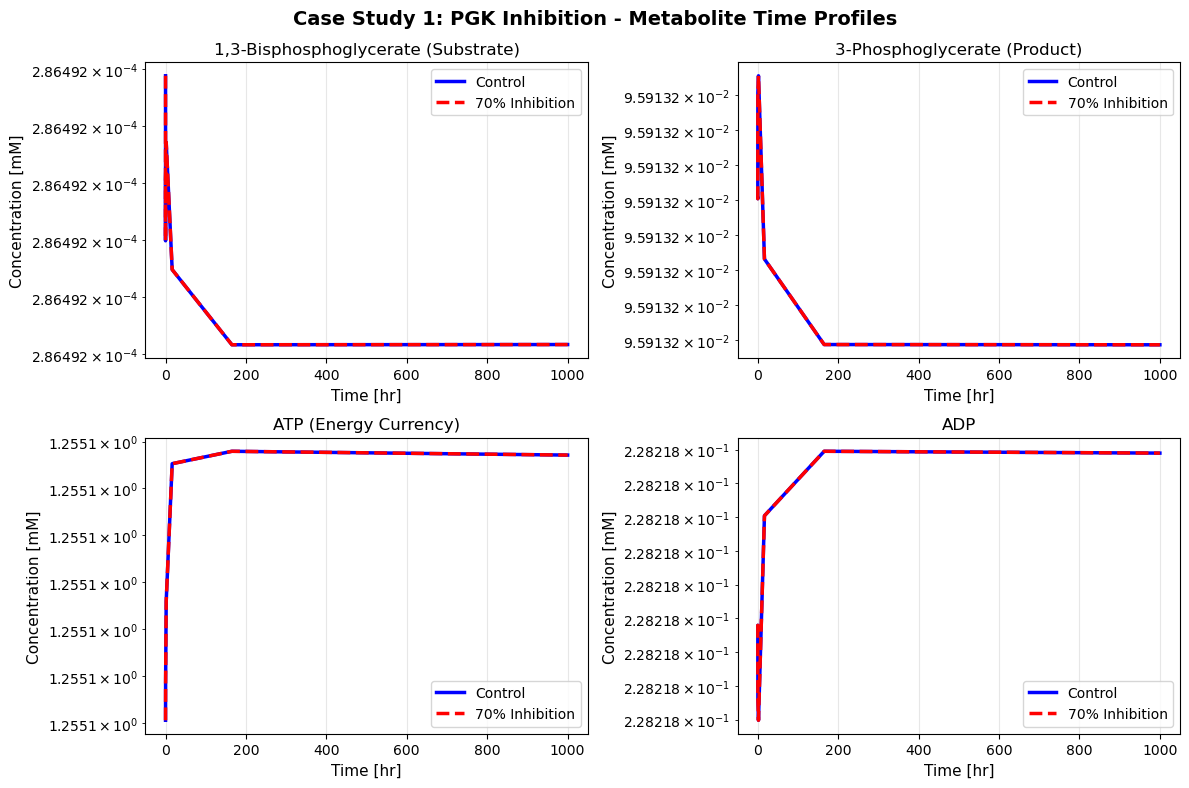

Figure 1 saved: case1_fig1_metabolites.png


In [7]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Case Study 1: PGK Inhibition - Metabolite Time Profiles', fontsize=14, fontweight='bold')

# Plot 1: 1,3-DPG (substrate)
axes[0, 0].semilogy(time_control, conc_control['_13dpg_c'], 'b-', linewidth=2.5, label='Control')
axes[0, 0].semilogy(time_inhibited, conc_inhibited['_13dpg_c'], 'r--', linewidth=2.5, label='70% Inhibition')
axes[0, 0].set_xlabel('Time [hr]', fontsize=11)
axes[0, 0].set_ylabel('Concentration [mM]', fontsize=11)
axes[0, 0].set_title('1,3-Bisphosphoglycerate (Substrate)', fontsize=12)
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: 3-PG (product)
axes[0, 1].semilogy(time_control, conc_control['_3pg_c'], 'b-', linewidth=2.5, label='Control')
axes[0, 1].semilogy(time_inhibited, conc_inhibited['_3pg_c'], 'r--', linewidth=2.5, label='70% Inhibition')
axes[0, 1].set_xlabel('Time [hr]', fontsize=11)
axes[0, 1].set_ylabel('Concentration [mM]', fontsize=11)
axes[0, 1].set_title('3-Phosphoglycerate (Product)', fontsize=12)
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: ATP
axes[1, 0].semilogy(time_control, conc_control['atp_c'], 'b-', linewidth=2.5, label='Control')
axes[1, 0].semilogy(time_inhibited, conc_inhibited['atp_c'], 'r--', linewidth=2.5, label='70% Inhibition')
axes[1, 0].set_xlabel('Time [hr]', fontsize=11)
axes[1, 0].set_ylabel('Concentration [mM]', fontsize=11)
axes[1, 0].set_title('ATP (Energy Currency)', fontsize=12)
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: ADP
axes[1, 1].semilogy(time_control, conc_control['adp_c'], 'b-', linewidth=2.5, label='Control')
axes[1, 1].semilogy(time_inhibited, conc_inhibited['adp_c'], 'r--', linewidth=2.5, label='70% Inhibition')
axes[1, 1].set_xlabel('Time [hr]', fontsize=11)
axes[1, 1].set_ylabel('Concentration [mM]', fontsize=11)
axes[1, 1].set_title('ADP', fontsize=12)
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(figures_dir, 'case1_fig1_metabolites.png'), dpi=300, bbox_inches='tight')
plt.show()

print("Figure 1 saved: case1_fig1_metabolites.png")

### Figure 2
WHY THIS FIGURE?
- Energy charge is THE key indicator of cellular energy status
- Left panel: Shows dynamics - how quickly energy is depleted
- Right panel: Compares final steady states with health thresholds
- Critical thresholds: >0.8 = healthy, <0.5 = critical dysfunction

KEY INSIGHTS:
- Temporal dynamics reveal adaptation time
- Final values show if cell can maintain viability
- Thresholds indicate clinical significance


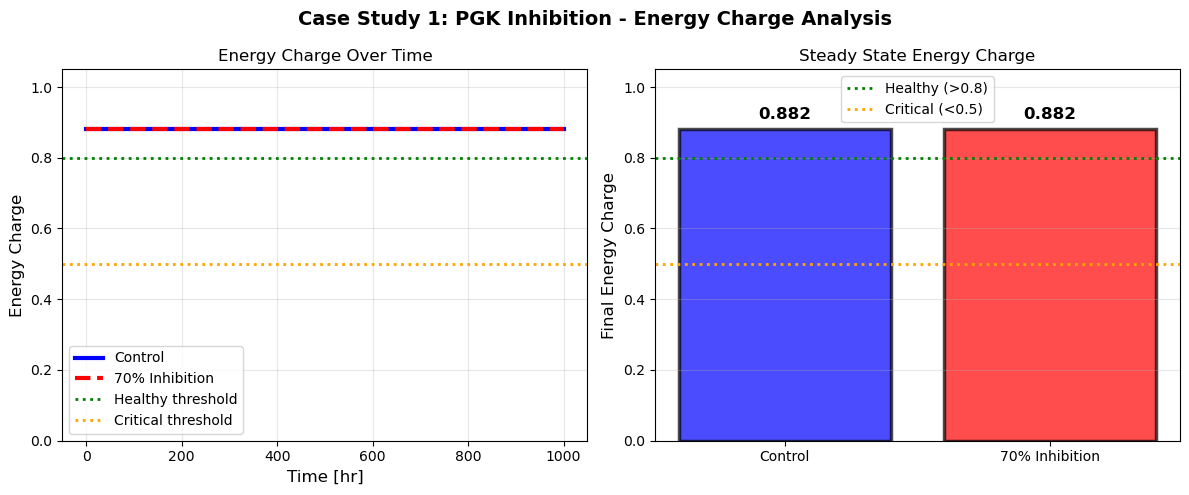

Figure 2 saved: case1_fig2_energy_charge.png


In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Case Study 1: PGK Inhibition - Energy Charge Analysis', fontsize=14, fontweight='bold')

# Left panel: Time course
axes[0].plot(time_control, ec_control, 'b-', linewidth=3, label='Control')
axes[0].plot(time_inhibited, ec_inhibited, 'r--', linewidth=3, label='70% Inhibition')
axes[0].axhline(y=0.8, color='green', linestyle=':', linewidth=2, label='Healthy threshold')
axes[0].axhline(y=0.5, color='orange', linestyle=':', linewidth=2, label='Critical threshold')
axes[0].set_xlabel('Time [hr]', fontsize=12)
axes[0].set_ylabel('Energy Charge', fontsize=12)
axes[0].set_title('Energy Charge Over Time', fontsize=12)
axes[0].set_ylim([0, 1.05])
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Right panel: Bar comparison
conditions = ['Control', '70% Inhibition']
final_ec = [ec_control[-1], ec_inhibited[-1]]
colors = ['blue', 'red']

bars = axes[1].bar(conditions, final_ec, color=colors, alpha=0.7, edgecolor='black', linewidth=2.5)
axes[1].axhline(y=0.8, color='green', linestyle=':', linewidth=2, label='Healthy (>0.8)')
axes[1].axhline(y=0.5, color='orange', linestyle=':', linewidth=2, label='Critical (<0.5)')
axes[1].set_ylabel('Final Energy Charge', fontsize=12)
axes[1].set_title('Steady State Energy Charge', fontsize=12)
axes[1].set_ylim([0, 1.05])
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, val in zip(bars, final_ec):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{val:.3f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(figures_dir, 'case1_fig2_energy_charge.png'), dpi=300, bbox_inches='tight')
plt.show()

print("Figure 2 saved: case1_fig2_energy_charge.png")

### Figure 3
WHY THIS FIGURE?
- Phase portraits show system trajectory through state space
- Reveals dynamic behavior: stability, oscillations, equilibria
- ATP vs ADP chosen because:
  * PGK directly interconverts ADP → ATP
  * Shows energy status in 2D space
  * Trajectories reveal if system reaches stable steady state
  
KEY INSIGHTS:
- Start and end points show initial perturbation and final adaptation
- Trajectory shape indicates transient dynamics
- Control vs inhibited paths show how perturbation alters system behavior
- Log-log scale captures multiple orders of magnitude

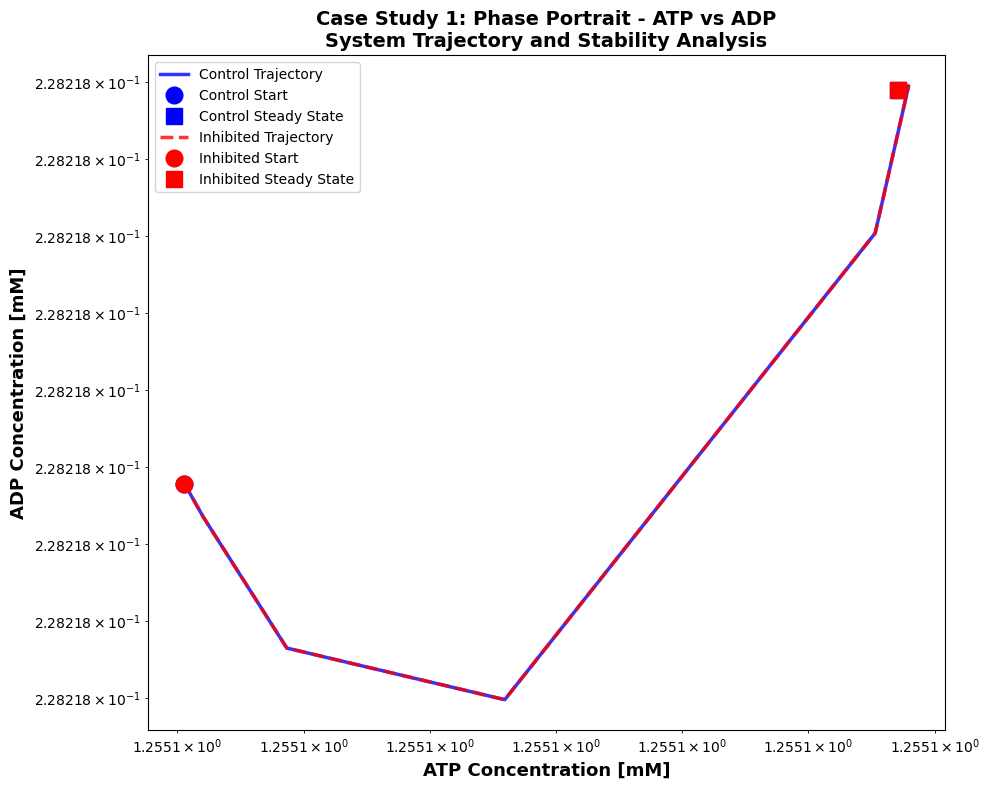

Figure 3 saved: case1_fig3_phase_portrait.png


In [9]:
fig, ax = plt.subplots(figsize=(10, 8))

# Control trajectory
ax.plot(conc_control['atp_c'], conc_control['adp_c'], 
        'b-', linewidth=2.5, alpha=0.8, label='Control Trajectory')
ax.plot(conc_control['atp_c'][0], conc_control['adp_c'][0], 
        'bo', markersize=12, label='Control Start', zorder=5)
ax.plot(conc_control['atp_c'][-1], conc_control['adp_c'][-1], 
        'bs', markersize=12, label='Control Steady State', zorder=5)

# Inhibited trajectory
ax.plot(conc_inhibited['atp_c'], conc_inhibited['adp_c'], 
        'r--', linewidth=2.5, alpha=0.8, label='Inhibited Trajectory')
ax.plot(conc_inhibited['atp_c'][0], conc_inhibited['adp_c'][0], 
        'ro', markersize=12, label='Inhibited Start', zorder=5)
ax.plot(conc_inhibited['atp_c'][-1], conc_inhibited['adp_c'][-1], 
        'rs', markersize=12, label='Inhibited Steady State', zorder=5)

ax.set_xlabel('ATP Concentration [mM]', fontsize=13, fontweight='bold')
ax.set_ylabel('ADP Concentration [mM]', fontsize=13, fontweight='bold')
ax.set_title('Case Study 1: Phase Portrait - ATP vs ADP\nSystem Trajectory and Stability Analysis', 
             fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xscale('log')
ax.set_yscale('log')

plt.tight_layout()
plt.savefig(os.path.join(figures_dir, 'case1_fig3_phase_portrait.png'), dpi=300, bbox_inches='tight')
plt.show()

print("Figure 3 saved: case1_fig3_phase_portrait.png")

In [10]:
print("\n" + "="*80)
print("CASE STUDY 1 COMPLETE")
print("="*80)
print(f"All figures saved to: {figures_dir}")
print("\nKEY FINDINGS:")
print(f"1. Baseline energy charge: {ec_control[-1]:.4f}")
print(f"2. Inhibited energy charge: {ec_inhibited[-1]:.4f}")
print(f"3. Energy charge reduction: {(ec_control[-1] - ec_inhibited[-1]):.4f}")
print(f"4. Cell viability: {'MAINTAINED' if ec_inhibited[-1] > 0.5 else 'COMPROMISED'}")


CASE STUDY 1 COMPLETE
All figures saved to: /Users/nick/Desktop/GitHub/RBC Simulations/figures

KEY FINDINGS:
1. Baseline energy charge: 0.8823
2. Inhibited energy charge: 0.8823
3. Energy charge reduction: 0.0000
4. Cell viability: MAINTAINED
